In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [21]:
from sklearn.metrics import mean_squared_error

In [2]:
sys.path.append("../")

In [3]:
from Transformers import ChannelsFirst, ToTensor, Cut, Rescale, splitter, splitter_train_val_test

In [4]:
from DataSets import UNetDataSetFromNpz, UNetDatasetFromFolders

In [5]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [6]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT

In [7]:
epochs=50
coeff_mask = 0.75

In [8]:
model_name = "../model/trained_cUNet_pytorch_regression_{}epochs_coeff_mask{}_validation_on_npz_notranspose.pkl".format(epochs, coeff_mask)

In [9]:
model_inference = cUNet(out_size=1)

In [10]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Test trained model on 15mm

In [12]:
folder_15mm = os.path.join(data_dir,"dataset", "first_batch", "10x10_15mm_clean")

In [13]:
composed = transforms.Compose([Cut(),Rescale(.25), ChannelsFirst(), ToTensor()])

In [14]:
dataset_15mm = UNetDatasetFromFolders(folder_15mm, transform=composed)

In [15]:
data_loader_15mm = DataLoader(dataset_15mm, batch_size=16, shuffle=True, num_workers=4)

In [16]:
model_inference.eval()
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

batch 1
1: true_dist: 15, pred_dist: [15.535206]


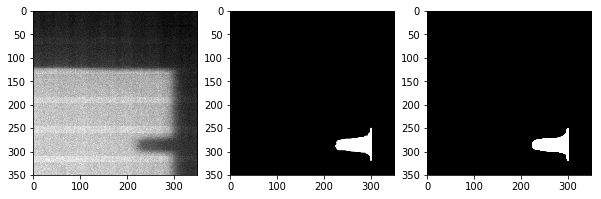

2: true_dist: 15, pred_dist: [15.513117]


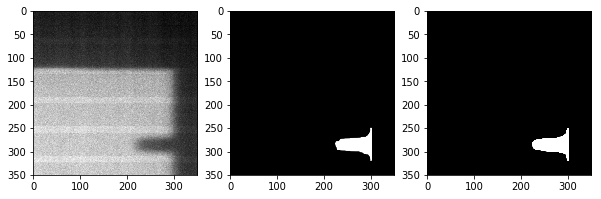

3: true_dist: 15, pred_dist: [15.3004055]


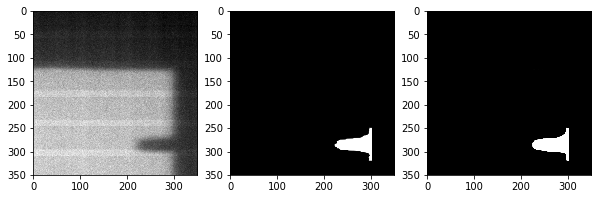

4: true_dist: 15, pred_dist: [15.461896]


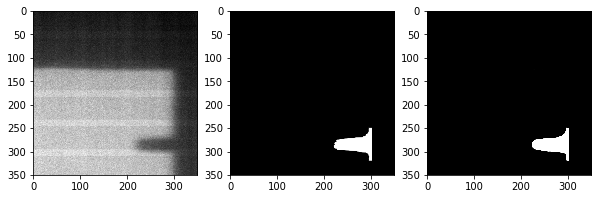

5: true_dist: 15, pred_dist: [15.424686]


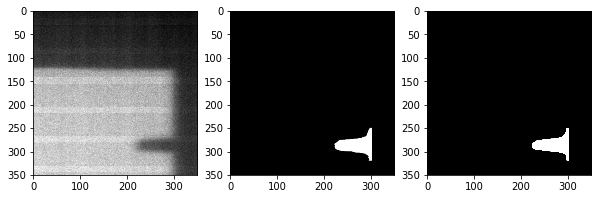

6: true_dist: 15, pred_dist: [15.344411]


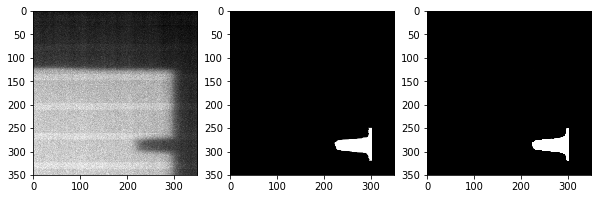

7: true_dist: 15, pred_dist: [15.433457]


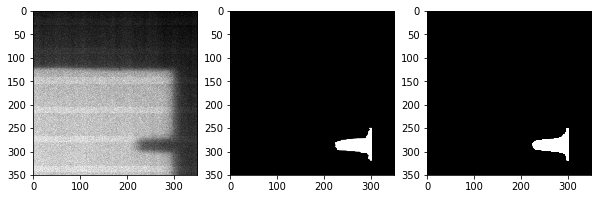

8: true_dist: 15, pred_dist: [15.40597]


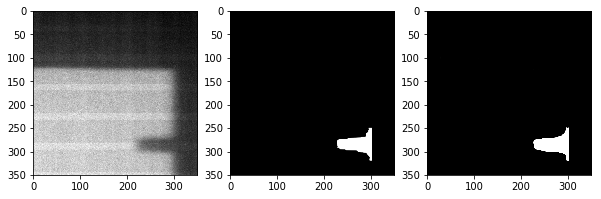

9: true_dist: 15, pred_dist: [15.250401]


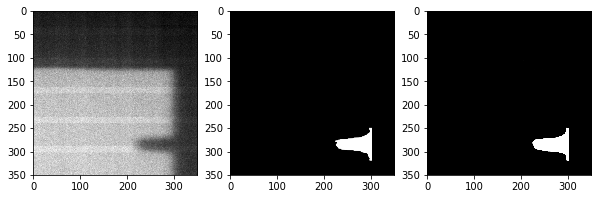

10: true_dist: 15, pred_dist: [15.616508]


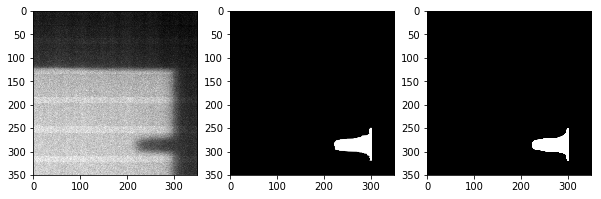

11: true_dist: 15, pred_dist: [15.345068]


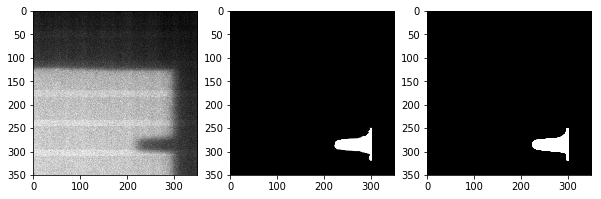

12: true_dist: 15, pred_dist: [15.31424]


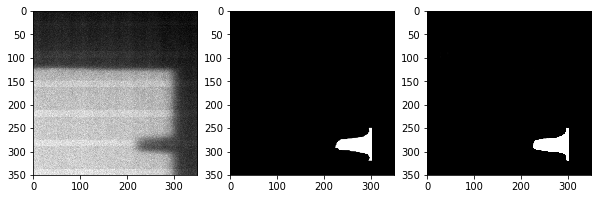

13: true_dist: 15, pred_dist: [15.34969]


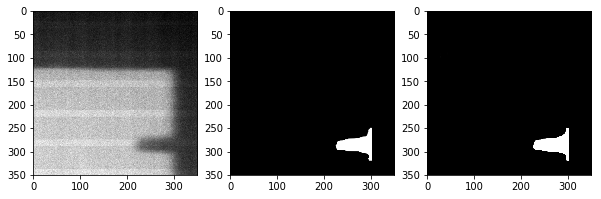

14: true_dist: 15, pred_dist: [15.296259]


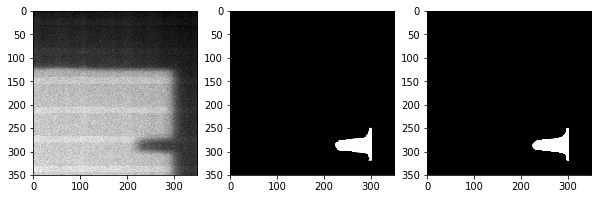

15: true_dist: 15, pred_dist: [15.445851]


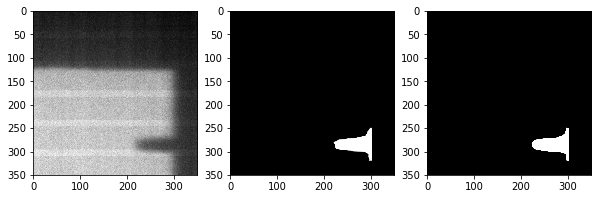

16: true_dist: 15, pred_dist: [15.432557]


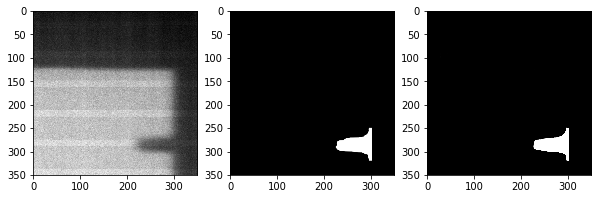

batch 2
1: true_dist: 15, pred_dist: [15.37121]


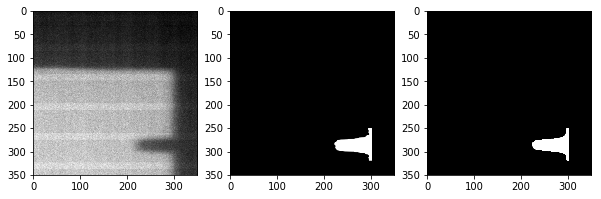

2: true_dist: 15, pred_dist: [15.28359]


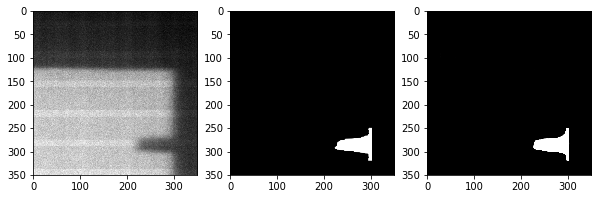

3: true_dist: 15, pred_dist: [15.320796]


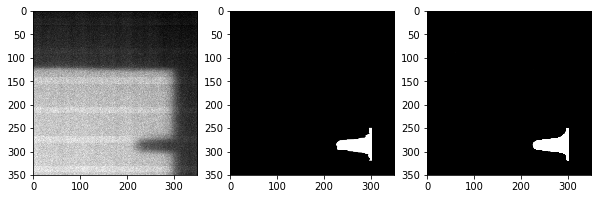

4: true_dist: 15, pred_dist: [15.375152]


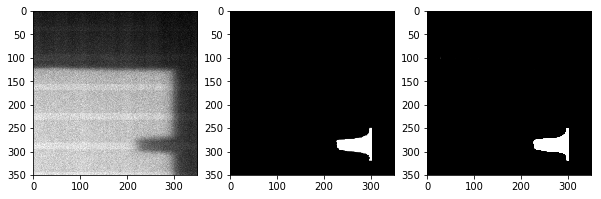

5: true_dist: 15, pred_dist: [15.449426]


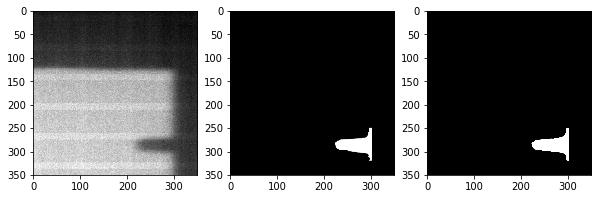

6: true_dist: 15, pred_dist: [15.397034]


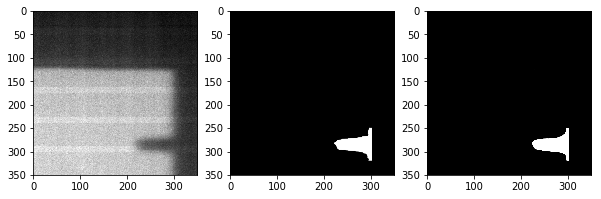

7: true_dist: 15, pred_dist: [15.493243]


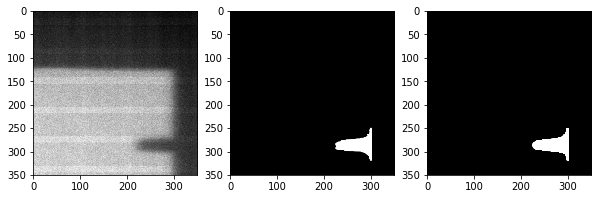

8: true_dist: 15, pred_dist: [15.480226]


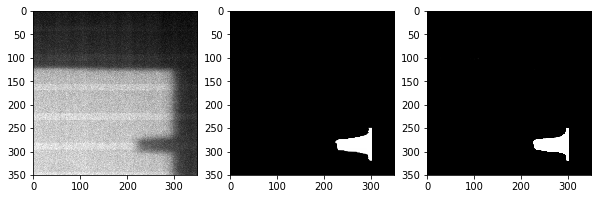

9: true_dist: 15, pred_dist: [15.679882]


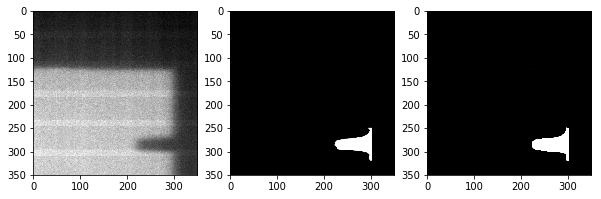

10: true_dist: 15, pred_dist: [15.673879]


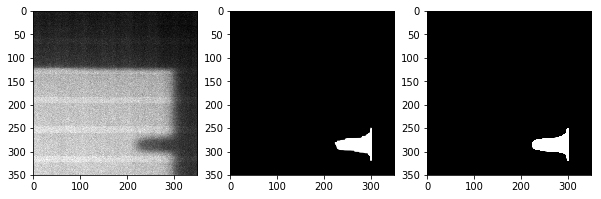

11: true_dist: 15, pred_dist: [15.500479]


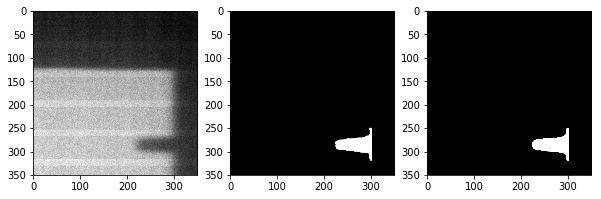

12: true_dist: 15, pred_dist: [15.630364]


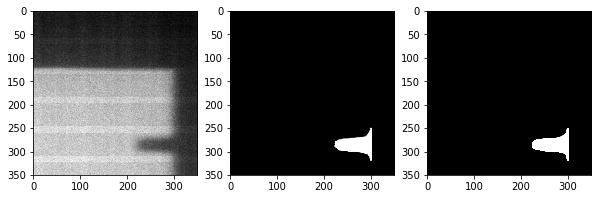

13: true_dist: 15, pred_dist: [15.337127]


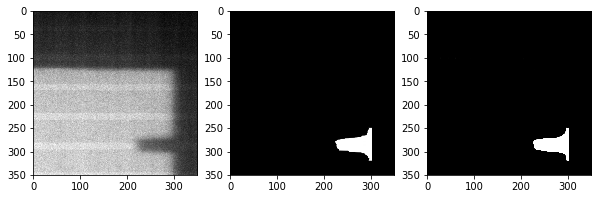

14: true_dist: 15, pred_dist: [15.50361]


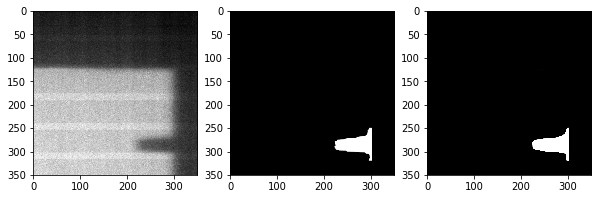

15: true_dist: 15, pred_dist: [15.395726]


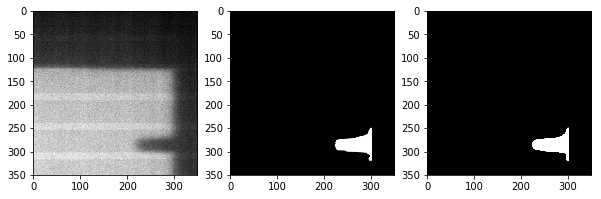

16: true_dist: 15, pred_dist: [15.216457]


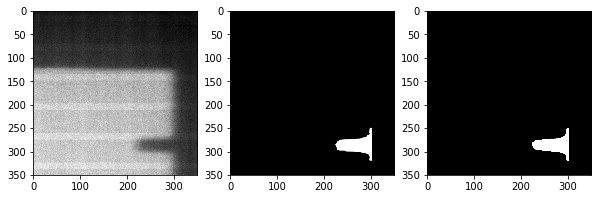

In [17]:
for i, batch in enumerate(data_loader_15mm):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [19]:
y_true_15mm = []
y_pred_15mm = []

for i, batch in enumerate(data_loader_15mm):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i + 1))
    for j, (img, tr_cl, pr_cl) in enumerate(zip(true_images,
                                                true_dists.cpu().detach().numpy(),
                                                pred_classes.cpu().detach().numpy())):
        true_dist = tr_cl
        pred_dist = pr_cl
        y_true_15mm.append(true_dist)
        y_pred_15mm.append(pred_dist)




batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19


In [22]:
y_pred_15mm = np.asarray(y_pred_15mm).ravel()
y_true_15mm = np.asarray(y_true_15mm)

print("mse: {}".format(mean_squared_error(y_true_15mm, y_pred_15mm)))

mse: 0.21195150013583164
